In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Pool
import time
import dill
from PIL import Image
from collections import defaultdict
import pyamg
from os import listdir
from os.path import isfile, join


In [2]:
def stats(A):
    return A.dtype, A.shape, np.min(A), np.median(A), np.max(A)

def get_maximum(A):
    init = A[0]
    for a in A[1:]:
        init = np.maximum(a, init)
    return init


In [44]:
folder = './img_k/'
imgs_files = [f for f in listdir(folder) if isfile(join(folder, f))]
imgs_files

['IMG_20200613_014119.jpg',
 'IMG_20200613_014128.jpg',
 'IMG_20200613_014132.jpg',
 'IMG_20200613_014144.jpg']

In [8]:
imgs = []
for img in imgs_files:
    imgs.append(cv2.imread(folder + img, 0))

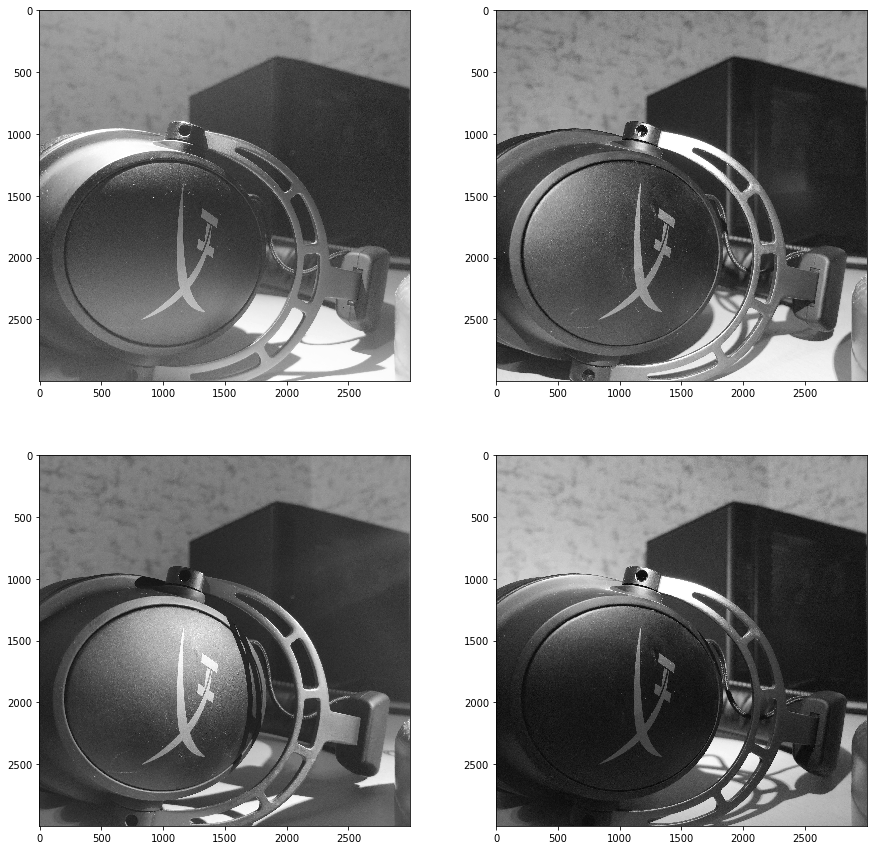

In [12]:
f, axarr = plt.subplots(2,2, figsize=(15,15))
axarr[0,0].imshow(imgs[0], cmap='gray')
axarr[0,1].imshow(imgs[1], cmap='gray')
axarr[1,0].imshow(imgs[2], cmap='gray')
axarr[1,1].imshow(imgs[3], cmap='gray')

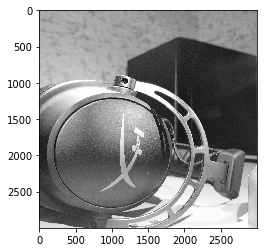

In [13]:
I_max = get_maximum(imgs)
plt.imshow(I_max, cmap='gray')

mb sobel

## Calculate intensity gradients $G_k$ gradients of $I_k$. Sobel and numpy

In [14]:
G_sobel_x = []
G_sobel_y = []
G_np_x = []
G_np_y = []
# G = []
for circle in imgs:
    
    sobelx = cv2.Sobel(circle,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(circle,cv2.CV_64F,0,1,ksize=5)
    G_sobel_x.append(sobelx)
    G_sobel_y.append(sobely)
    
    print(f"stats X: {stats(sobelx)}")
    print(f"stats Y: {stats(sobely)}")
    
    print("=" * 20)
    
    g_y, g_x = np.gradient(circle)
    G_np_x.append(g_x)
    G_np_y.append(g_y)    
    
    print(f"g_x : {stats(g_x)}")
    print(f"g_y : {stats(g_y)}")
    
    print("-" * 20)
    



stats X: (dtype('float64'), (3000, 3000), -9052.0, 0.0, 6822.0)
stats Y: (dtype('float64'), (3000, 3000), -8360.0, 0.0, 7783.0)
g_x : (dtype('float64'), (3000, 3000), -105.0, 0.0, 79.0)
g_y : (dtype('float64'), (3000, 3000), -89.5, 0.0, 79.5)
--------------------
stats X: (dtype('float64'), (3000, 3000), -9894.0, -1.0, 8833.0)
stats Y: (dtype('float64'), (3000, 3000), -10341.0, 0.0, 8247.0)
g_x : (dtype('float64'), (3000, 3000), -107.0, 0.0, 107.5)
g_y : (dtype('float64'), (3000, 3000), -106.5, 0.0, 88.0)
--------------------
stats X: (dtype('float64'), (3000, 3000), -9298.0, 2.0, 7282.0)
stats Y: (dtype('float64'), (3000, 3000), -8563.0, -2.0, 8558.0)
g_x : (dtype('float64'), (3000, 3000), -102.5, 0.0, 85.0)
g_y : (dtype('float64'), (3000, 3000), -99.0, 0.0, 88.0)
--------------------
stats X: (dtype('float64'), (3000, 3000), -9429.0, -1.0, 8563.0)
stats Y: (dtype('float64'), (3000, 3000), -9878.0, -2.0, 8903.0)
g_x : (dtype('float64'), (3000, 3000), -95.5, 0.0, 99.0)
g_y : (dtype('fl

## $G$ median of gradients ($G(x, y)= median_{k} (G_k(x,y))$). Sobel and numpy

In [15]:
G_sobel_median_x = np.median(G_sobel_x, axis=0)
G_sobel_median_y = np.median(G_sobel_y, axis=0)

G_np_median_x = np.median(G_np_x, axis=0)
G_np_median_y = np.median(G_np_y, axis=0)

In [16]:
print(f"sobel_x median: {stats(G_sobel_median_x)}")
print(f"numpy_x median: {stats(G_np_median_x)}")

sobel_x median: (dtype('float64'), (3000, 3000), -7428.0, 0.0, 6021.0)
numpy_x median: (dtype('float64'), (3000, 3000), -79.5, 0.0, 70.75)


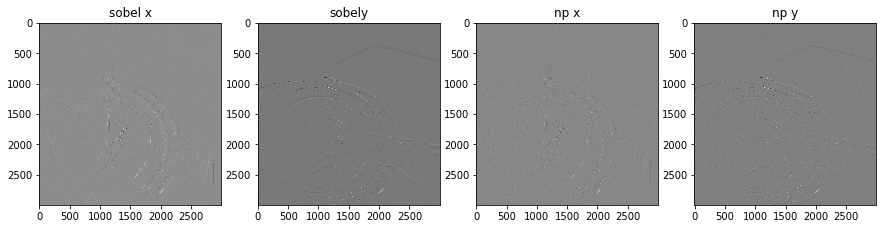

In [17]:
f, ax = plt.subplots(1,4, figsize=(15,15) )
ax[0].set_title("sobel x")
ax[0].imshow(G_sobel_median_x, cmap='gray')

ax[1].set_title("sobely")
ax[1].imshow(G_sobel_median_y, cmap='gray')

ax[2].set_title("np x")
ax[2].imshow(G_np_median_x, cmap='gray')

ax[3].set_title("np y")
ax[3].imshow(G_np_median_y, cmap='gray')

## Poisson equation

### divergence of the vector field G

In [18]:
sobelx = cv2.Sobel(G_sobel_median_x,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(G_sobel_median_y,cv2.CV_64F,0,1,ksize=5)
div_G_sobel = sobelx + sobely

x_x, x_y = np.gradient(G_np_median_x)
y_x, y_y = np.gradient(G_np_median_y)
div_G_np = x_x + y_y

In [19]:
print(f"div_G_sobel: {stats(div_G_sobel)}")
print(f"div_G_np: {stats(div_G_np)}")

div_G_sobel: (dtype('float64'), (3000, 3000), -542948.0, 59.0, 451878.5)
div_G_np: (dtype('float64'), (3000, 3000), -57.625, 0.0, 75.125)


### Solver

In [20]:
def calc_R(alpha, I, I_max):
    return alpha * I + (1 - alpha) * I_max

In [21]:
def solve_poisson(shape, div_G):
    A = pyamg.gallery.poisson(shape, format='csr')  # 2D Poisson problem on 500x500 grid
    ml = pyamg.ruge_stuben_solver(A)                    # construct the multigrid hierarchy
    print(ml)                                           # print hierarchy information
    b = div_G.ravel()
    x = ml.solve(b, tol=1e-10)
    print("residual: ", np.linalg.norm(b-A*x)) 
    return x

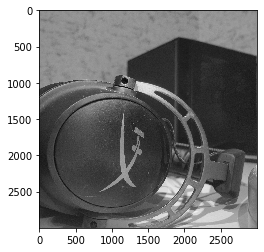

In [22]:
I_median = np.median(imgs, axis=0)
plt.imshow(I_median.astype('uint8'), cmap='gray')

#### By color img

In [24]:
shape = imgs[0].shape
size = shape[0]

#### Sobel

In [25]:
%%time
colors_sobel = cv2.split(div_G_sobel)
ans = solve_poisson(shape, div_G_sobel).reshape(-1, size)

D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.203
Grid Complexity:      1.667
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0      9000000     44988000 [45.40%]
    1      4500000     40476002 [40.84%]
    2      1125002     10119644 [10.21%]
    3       280959      2584451 [ 2.61%]
    4        70308       690736 [ 0.70%]
    5        17442       179402 [ 0.18%]
    6         4348        45802 [ 0.05%]
    7         1069        11389 [ 0.01%]
    8          266         2970 [ 0.00%]
    9           66          716 [ 0.00%]

residual:  0.002278273847842106
Wall time: 44.9 s


In [28]:
print(f"ans: {stats(ans)}")

ans: (dtype('float64'), (3000, 3000), -1704398.7339370158, 231889.0008308327, 1738225.2474992068)


In [29]:
test = np.copy(-1 * ans)
test -= np.min(test)
test /= np.max(test) / 255
test[test > 255] = 255
print(f"test: {stats(test)}")

test: (dtype('float64'), (3000, 3000), 0.0, 111.5764442970582, 255.0)


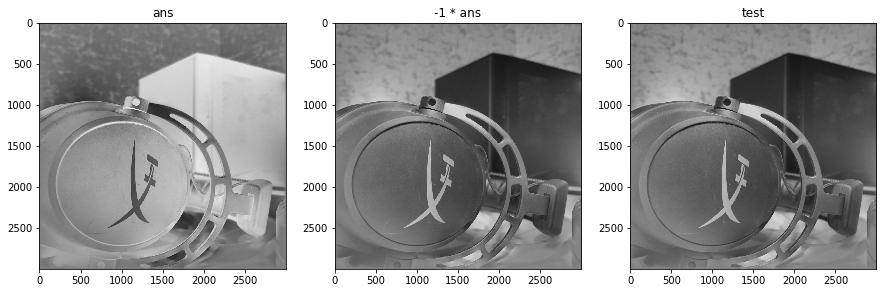

In [30]:
f, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].set_title("ans")
ax[1].set_title("-1 * ans")
ax[2].set_title("test")

ax[0].imshow(ans, cmap='gray')
ax[1].imshow(-1*ans, cmap='gray')
ax[2].imshow(test, cmap='gray')

In [61]:
print(f"I_max : {stats(I_max)}")

I_max : (dtype('uint8'), (640, 640), 0, 192.0, 255)


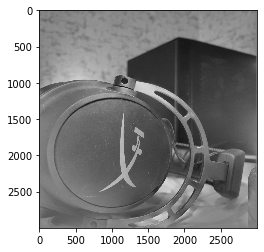

In [31]:
R = calc_R(0.8, -1*ans, I_max)
plt.imshow(R, cmap='gray')

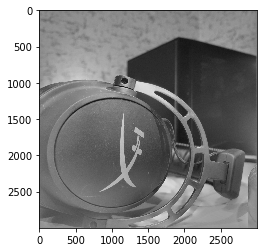

In [34]:
R = calc_R(0.8, test, I_max)
plt.imshow(R, cmap='gray')

In [64]:
imgs_с = []
for img in imgs_files:
#     imgs_с.append(cv2.imread(folder + img))    
    imgs_с.append(cv2.cvtColor(cv2.imread(folder + img), cv2.COLOR_BGR2RGB))

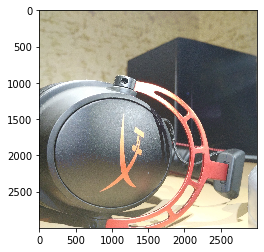

In [71]:
I_max_c = get_maximum(imgs_с)
plt.imshow(I_max_c)

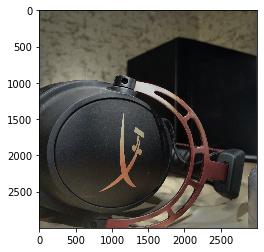

In [70]:
r, g, b = cv2.split(I_max_c / 255)
R = cv2.merge([(r * test).astype('uint8'), (g*test).astype('uint8'), (b*test).astype('uint8')])
plt.imshow(R)

In [67]:
R = ((I_max_c / 255) * test).astype('uint8')
plt.imshow(R)

ValueError: operands could not be broadcast together with shapes (3000,3000,3) (3000,3000) 

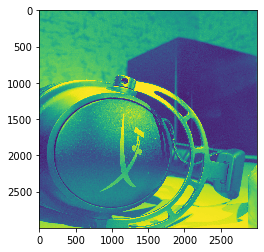

In [63]:
plt.imshow(I_max)